<a href="https://colab.research.google.com/github/Simone999/nlp_assignment1/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [ ]:
import os
import functools
from typing import List, Callable, Dict, Iterable
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import keras as ks

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/My Drive/dependency_treebank" "dependency_treebank"

Mounted at /content/drive


structuring dataframe

In [ ]:
dataset_name = "dependency_treebank"
dataset_path = os.path.join(os.getcwd(), dataset_name)
end_train = 100
end_validation = 150
end_test = 199

def create_dataset(start, end, split:str):
  tagged_sentences = []
  for data_file in range(start, end+1):
    filename = os.path.join(dataset_path, "wsj_%04d.dp" % data_file)
    with open(filename, mode='r', encoding='utf-8') as text_file:  
      corpus = text_file.read()
      tagged_sentences += corpus.split("\n\n")

  X = [] # store input sequence
  Y = [] # store output sequence
  for sentence in tqdm(tagged_sentences):
      X_sentence = []
      Y_sentence = []

      for tagged_word in sentence.rstrip('\n').split("\n"):       
          entity = tagged_word.split("\t")
          X_sentence.append(entity[0])  # entity[0] contains the word
          Y_sentence.append(entity[1])  # entity[1] contains corresponding tag          
      X.append(X_sentence)
      Y.append(Y_sentence)

  assert len(tagged_sentences) == len(X)

  df = pd.DataFrame({'sentence':X, 'tags':Y})
  df['split'] = split
  return df

train_set = create_dataset(1, end_train, 'train')
val_set = create_dataset(end_train+1, end_validation, 'validation')
test_set = create_dataset(end_validation, end_test, 'test')
dataset = pd.concat([train_set, val_set, test_set])

dataset

100%|██████████| 661/661 [00:00<00:00, 38223.61it/s]


,sentence,tags,split
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train
...,...,...,...
656,"[They, also, said, that, more, than, a, dozen,...","[PRP, RB, VBD, IN, JJR, IN, DT, NN, NNS, VBP, ...",test
657,"[Sen., Kennedy, said, in, a, separate, stateme...","[NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",test
658,"[Trinity, Industries, Inc., said, it, reached,...","[NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",test
659,"[Terms, were, n't, disclosed, .]","[NNS, VBD, RB, VBN, .]",test


In [ ]:
words = set([word.lower() for sentence in dataset.sentence for word in sentence])
tags = list(set([tag for sentence in dataset.tags for tag in sentence]))
n_words = len(words)
n_tags   = len(tags)

print("Total number of tagged sentences: {}".format(len(dataset)))
print("Vocabulary size: {}".format(n_words))
print("Total number of tags: {}".format(n_tags))
print()
print('Tags')
print(tags)

Total number of tagged sentences: 3923
Vocabulary size: 10947
Total number of tags: 45

Tags
["''", 'NNS', 'RBS', 'VB', ':', 'PRP$', 'NN', 'JJ', 'VBN', 'VBP', 'WP', 'UH', ',', 'NNP', 'CC', 'JJR', 'EX', 'RBR', 'FW', 'SYM', 'VBZ', 'MD', '-LRB-', '``', 'WRB', '#', 'JJS', 'RP', 'WDT', 'NNPS', 'CD', 'VBG', 'DT', 'IN', 'POS', 'RB', 'PRP', '$', 'PDT', '-RRB-', '.', 'VBD', 'WP$', 'TO', 'LS']


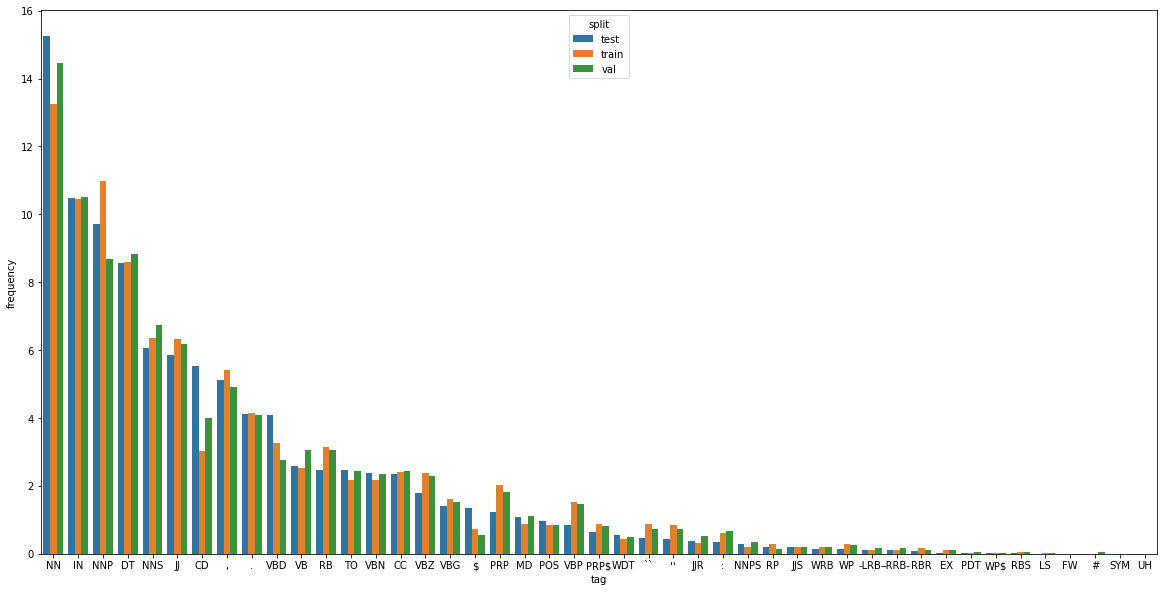

In [ ]:
# Plot label distributions

def flatten(arr):
  return [item for sublist in arr for item in sublist]

def flatten_tags_by_split(dataset):
  train_data = flatten(dataset.loc[dataset['split'] == 'train', 'tags'])
  val_data = flatten(dataset.loc[dataset['split'] == 'validation', 'tags'])
  test_data = flatten(dataset.loc[dataset['split'] == 'test', 'tags'])

  train_data = pd.DataFrame(train_data, columns=['tag'])
  train_data['split'] = 'train'
  val_data = pd.DataFrame(val_data, columns=['tag'])
  val_data['split'] = 'val'
  test_data = pd.DataFrame(test_data, columns=['tag'])
  test_data['split'] = 'test'

  return pd.concat([train_data, val_data, test_data])

def plot_tags_distribution(data, title: str):
    fig, ax = plt.subplots(figsize=(20, 10))
    (data
    .groupby('split')['tag']
    .value_counts(normalize=True)
    .mul(100)
    .rename('frequency')
    .reset_index()
    .pipe((sns.barplot,'data'), x='tag', y='frequency', hue='split', ax=ax)
    );

    return data

tags_per_split = flatten_tags_by_split(dataset)
plot_tags_distribution(tags_per_split, 'Tags distribution');

In [ ]:
label_counts = pd.get_dummies(tags_per_split, columns=['tag'], prefix='', prefix_sep='').groupby('split').sum().reset_index()
tags = label_counts.columns[1:]
count_by_split = np.expand_dims(label_counts[tags].sum(axis=1), axis=1)
label_counts[tags] = label_counts[tags] / count_by_split
label_counts = label_counts.T.reset_index().rename(columns={'index':'tag', 0:'test', 1:'train', 2:'val'})[1:]
label_counts

,tag,test,train,val
1,#,0.0,0.000021,0.000481
2,$,0.013495,0.007222,0.005548
3,'',0.004456,0.008426,0.007215
4,",",0.051117,0.054291,0.049001
5,-LRB-,0.001146,0.001098,0.001603
6,-RRB-,0.001146,0.001161,0.0017
7,.,0.041187,0.041368,0.040952
8,:,0.003565,0.006187,0.006863
9,CC,0.02349,0.024094,0.024308
10,CD,0.055255,0.030387,0.040054


In [ ]:
label_counts.loc[(label_counts == 0).any(axis=1)]

,tag,test,train,val
1,#,0.0,0.000021,0.000481
13,FW,0.0,0.000042,0.000064
18,LS,0.0,0.000211,0.000096
32,SYM,0.0,0.000021,0.0
34,UH,0.0,0.000021,0.000064


# Glove embeddings

In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str='glove', embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

embedding_dimension=50
embedding_model = load_embedding_model(model_type="glove", embedding_dimension=embedding_dimension)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
def get_words(sentences: List[str]):
  return set(token for tokens in sentences for token in tokens)

class Tokenizer:
  def __init__(self, vocabulary=None, padding='<PAD>'):
    """
    Transform a set of sentences in a set of indices.
    The order of enumeration respects the order of the set of sentences used in the fit_on_texts method.
    """
    self.word_to_index = {padding: 0}
    self.idx_to_word = {0: padding}
    self.__idx = 1

    if vocabulary:
      self.update_vocabulary(vocabulary)

  def get_oov_terms(self, words):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    words_in_vocabulary = set(self.word_to_index.keys())
    oov = set(words).difference(words_in_vocabulary)
    return list(oov)

  def update_vocabulary(self, sentences, verbose=True):
    """
    Update the vocabulary by looking at the list of sentences in input
    """
    
    words = get_words(sentences) 
    oov_terms = self.get_oov_terms(words)

    old_len = len(self.word_to_index)
    self.__expand_vocabulary(oov_terms)

    if verbose:
      oov_percentage = float(len(oov_terms)) * 100 / len(words)
      print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

      print("Vocabulary length before expansion:", old_len)
      print("Vocabulary length after expansion:", len(self.word_to_index))

    return oov_terms

  def __expand_vocabulary(self, oov_terms: Iterable[str]):
    for term in oov_terms:
      self.word_to_index[term] = self.__idx
      self.idx_to_word[self.__idx] = term
      self.__idx += 1

  def texts_to_sequences(self, sentences) -> List[List[int]]:
    """
    Transform a list of sentences in a list of sequences, according to the current vocabulary
    """
    return list(map(self.text_to_sequence, sentences))

  def text_to_sequence(self, sentence) -> List[int]:
    return list(map(lambda token: self.word_to_index[token], sentence))

  def sequences_to_texts(self, sequences):
    """
    Transform a list of sequences in a list of sentences, according to the current vocabulary
    """
    return list(map(self.sequence_to_text, sequences))
  
  def sequence_to_text(self, sequence):
    return list(map(lambda idx: self.idx_to_word[idx], sequence))

class EmbeddingMatrix():
  def __init__(self,
               embedding_model: gensim.models.keyedvectors.KeyedVectors,
               embedding_dimension,
               word_to_idx: Dict[str, int],
               oov_vector_factory = None) -> None:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: dimension of the vectors in the embedding space
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    self.oov_vector_factory = oov_vector_factory if oov_vector_factory else lambda: np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

    vocab_size = len(word_to_idx)
    self.embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
      if word in embedding_model:
        embedding_vector = embedding_model[word]
      else:
        embedding_vector = self.oov_vector_factory()

      self.embedding_matrix[idx] = embedding_vector

  def update_matrix(self, word_to_idx: Dict[str, int]):
    old_vocab_size = len(self.embedding_matrix)
    vocab_size = len(word_to_idx)
    embedding_dimension = self.embedding_matrix.shape[1]

    self.embedding_matrix.resize((vocab_size, embedding_dimension))
    for word, idx in tqdm(word_to_idx.items()):
      if idx > old_vocab_size -1:
        self.embedding_matrix[idx] = self.oov_vector_factory()

  def as_numpy(self):
    return self.embedding_matrix

In [ ]:
def add_oov(dataset, dataset_name: str):
  print()
  print(f'Adding {dataset_name} vocabulary ...')
  tokenizer.update_vocabulary(dataset.sentence)
  embedding_matrix.update_matrix(tokenizer.word_to_index)

tokenizer = Tokenizer([embedding_model.vocab.keys()])
embedding_matrix = EmbeddingMatrix(embedding_model, embedding_dimension, tokenizer.word_to_index)

add_oov(train_set, 'training set')
add_oov(val_set, 'validation set')
add_oov(test_set, 'test set')

print('\n')
print('Shape of the embedding matrix', embedding_matrix.as_numpy().shape)

Total OOV terms: 400000 (100.00%)
Vocabulary length before expansion: 1
Vocabulary length after expansion: 400001


100%|██████████| 400001/400001 [00:02<00:00, 162426.10it/s]



Adding training set vocabulary ...
Total OOV terms: 2346 (29.29%)
Vocabulary length before expansion: 400001
Vocabulary length after expansion: 402347


100%|██████████| 402347/402347 [00:00<00:00, 1553467.23it/s]



Adding validation set vocabulary ...
Total OOV terms: 944 (16.02%)
Vocabulary length before expansion: 402347
Vocabulary length after expansion: 403291


100%|██████████| 403291/403291 [00:00<00:00, 1582470.67it/s]



Adding test set vocabulary ...
Total OOV terms: 455 (12.49%)
Vocabulary length before expansion: 403291
Vocabulary length after expansion: 403746


100%|██████████| 403746/403746 [00:00<00:00, 1451562.51it/s]



Shape of the embedding matrix (403746, 50)


In [ ]:
embedding = embedding_matrix.as_numpy()
print(embedding.shape)
embedding

(403746, 50)


array([[-0.04734939, -0.01652002, -0.03929646, ...,  0.04843136,
         0.04691343, -0.02120133],
       [ 0.74751   , -1.2892    , -0.39371   , ...,  0.40111   ,
        -0.62388   , -0.048984  ],
       [ 0.18607   , -0.49903   , -0.33945   , ...,  0.81336   ,
        -0.24756   ,  0.16771   ],
       ...,
       [ 0.04498839, -0.04319157, -0.03965253, ...,  0.00920012,
         0.00913327,  0.03489016],
       [ 0.02478843,  0.03671597, -0.01459689, ..., -0.01147853,
         0.01035016,  0.00316977],
       [-0.03663756, -0.02441949, -0.04559055, ...,  0.00293957,
        -0.01667591,  0.04902021]], dtype=float32)

Let's choose the length of the sentences by giving a look to our data.

In [ ]:
def get_lengths(x: List[List]):
  return np.array([len(seq) for seq in x])

lengths = get_lengths(train_set.sentence)
pd.Series(lengths).describe()

count    1963.0000
mean       24.1243
std        12.6045
min         1.0000
25%        16.0000
50%        23.0000
75%        31.0000
max       249.0000
dtype: float64

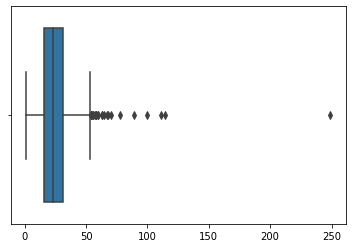

In [ ]:
sns.boxplot(x=lengths);

In [ ]:
max_seq_length = int(np.quantile(lengths, .99))
print('Max length chosen:', max_seq_length)
print('Sentences longer that max_seq_length:', np.count_nonzero(lengths > max_seq_length), '/', len(lengths))

Max length chosen: 56
Sentences longer that max_seq_length: 19 / 1963


In [ ]:
def prepare_dataset(dataset: pd.DataFrame, max_seq_length, n_tags):
  encoded_sentences = tokenizer.texts_to_sequences(dataset.sentence)
  encoded_sentences = ks.utils.pad_sequences(encoded_sentences, maxlen=max_seq_length, padding="post", truncating="post")

  encoded_tags = label_tokenizer.texts_to_sequences(dataset.tags)
  encoded_tags = ks.utils.pad_sequences(encoded_tags, maxlen=max_seq_length, padding="post", truncating="post")
   # n_tags+1: consider padding as class
  encoded_tags = ks.utils.to_categorical(encoded_tags, num_classes=n_tags+1)

  return encoded_sentences, encoded_tags

def create_dataloader(dataset: pd.DataFrame, preprocessing, batch_size=32):
  encoded_sentences, encoded_tags = preprocessing(dataset)

  return (
      tf.data.Dataset.from_tensor_slices((encoded_sentences, encoded_tags))      
      # .map() do here encoding and so one on the whole dataset
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      # .cache()
      .shuffle(buffer_size=2048)
      .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
      )

label_tokenizer = Tokenizer()
label_tokenizer.update_vocabulary(dataset.tags, verbose=False)
preprocessing = functools.partial(prepare_dataset, max_seq_length=max_seq_length, n_tags=n_tags)

ds = create_dataloader(train_set, preprocessing)
batched_text, batched_tags = next(ds.take(1).as_numpy_iterator())
text = batched_text[0]
tags = batched_tags[0]

print('Encode text:', text.shape)
print(text)
print('One hot encoded tags:', tags.shape)
print(tags)

Encode text: (56,)
[400688 356350 302183  75087  87059 325786 170598 401141  83964  79829
 312690 359734  54619  62796 246457 234288 300746 223020 234288  97138
 292617 302183 376139  87059  98575  94496  18683 109658 376934 156182
 175551  18670 234287 234288  28029 339701 249939 323183 324279 261849
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
One hot encoded tags: (56, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
embedding_weights = embedding_matrix.as_numpy()
embedding = ks.layers.Embedding(*embedding_weights.shape, weights=[embedding_weights], mask_zero=True)
embedding(tf.expand_dims(text, axis=0))

<tf.Tensor: shape=(1, 56, 50), dtype=float32, numpy=
array([[[-0.00798373, -0.01592998, -0.00990925, ..., -0.00714037,
         -0.03152749, -0.03178437],
        [-0.30461   , -1.4674    ,  1.0339    , ...,  0.47243   ,
          0.85753   , -0.25246   ],
        [ 0.70853   ,  0.57088   , -0.4716    , ..., -0.22562   ,
         -0.093918  , -0.80375   ],
        ...,
        [-0.04734939, -0.01652002, -0.03929646, ...,  0.04843136,
          0.04691343, -0.02120133],
        [-0.04734939, -0.01652002, -0.03929646, ...,  0.04843136,
          0.04691343, -0.02120133],
        [-0.04734939, -0.01652002, -0.03929646, ...,  0.04843136,
          0.04691343, -0.02120133]]], dtype=float32)>

# Network baseline

In [ ]:
def create_model(embedding_weights, n_labels):
  inputs = ks.layers.Input(shape=(None, ))
  x = ks.layers.Embedding(*embedding_weights.shape, weights=[embedding_weights], mask_zero=True)(inputs)
  x = ks.layers.Bidirectional(ks.layers.LSTM(units=64, return_sequences=True))(x)
  x = ks.layers.TimeDistributed(ks.layers.Dense(n_labels, activation='softmax'))(x)

  return ks.models.Model(inputs, x)


embedding_weights = embedding_matrix.as_numpy()
model = create_model(embedding_weights, n_labels=n_tags+1)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_35 (Embedding)    (None, None, 50)          20187300  
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, None, 46)         5934      
 tributed)                                                       
                                                                 
Total params: 20,252,114
Trainable params: 20,252,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size=128
epochs = 3

train_ds = create_dataloader(train_set, preprocessing, batch_size=batch_size)
val_ds = create_dataloader(val_set, preprocessing, batch_size=batch_size)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
16/16 [==============================] - 29s 1s/step - loss: 1.5087 - accuracy: 0.1258 - val_loss: 1.3396 - val_accuracy: 0.2155
Epoch 2/3
16/16 [==============================] - 14s 887ms/step - loss: 1.2525 - accuracy: 0.2479 - val_loss: 1.1818 - val_accuracy: 0.3280
Epoch 3/3
16/16 [==============================] - 13s 802ms/step - loss: 1.1195 - accuracy: 0.3612 - val_loss: 1.0588 - val_accuracy: 0.4197


# Evaluation

In [ ]:
# Take best models according to f1 score on validation set
def get_best_models(n=2):
  '''
  Take best models according to f1 score on validation set
  '''
  return [model]


@tf.function
def tf_in(x, y):
  '''
  Returns True for each value of x in y
  '''

  # Exploit broadcasting to compute y_true in filters
  # x:      N x 1
  # y:      M
  # x==y :  N x M
  # mask:   N

  x = tf.expand_dims(x, axis=-1) # x:  N x 1
  return tf.math.reduce_any(x==y, axis=-1)

@tf.function
def compute_padding_mask(y_true_hot):
  y_true = tf.argmax(y_true_hot, axis=-1)
  return y_true != 0

@tf.function
def compute_mask(y_true, black_list):
  return ~tf_in(y_true, black_list)

def predict(model, sentences):
  scores = model.predict(sentences)

  encoded_tags = np.argmax(scores, axis=-1)
  predicted_tags = label_tokenizer.sequences_to_texts(encoded_tags)  
  return np.array(predicted_tags)


def evaluate(model, dataset: pd.DataFrame, metric, banned_tags):
  # TODO: remove punctuation
  sentences, tags = preprocessing(dataset)
  y_pred = predict(model, sentences).reshape(-1)

  padding_mask = compute_padding_mask(tags)
  padding_mask = np.reshape(padding_mask, -1)  
  assert len(padding_mask) == len(y_pred), f'{len(padding_mask)} != {len(y_pred)}'

  y_true = test_set.tags.explode().to_numpy()
  y_pred = y_pred[padding_mask]
  assert y_pred.shape == y_true.shape, f'{y_pred.shape} != {y_true.shape}'

  mask = compute_mask(y_true, banned_tags)
  assert len(mask) == len(y_true), f'{len(mask)} != {len(y_true)}'
  assert len(mask) == len(y_pred), f'{len(mask)} != {len(y_pred)}'

  y_true = y_true[mask]
  y_pred = y_pred[mask]
  assert y_pred.shape == y_true.shape, f'{y_pred.shape} != {y_true.shape}'

  return y_true, y_pred, metric(y_true, y_pred)


best_models = get_best_models()
banned_tags = [',', '.', '``', "''", ':', '$', '-LRB-', '-RRB-', '#', 'SYM']
labels = list(np.setdiff1d(list(label_tokenizer.word_to_index.keys()), banned_tags + ['<PAD>']))
# metric = functools.partial(f1_score, average='macro')
metric = functools.partial(classification_report, zero_division=0, labels=labels)
seq_length = np.max(get_lengths(test_set.sentence))
preprocessing = functools.partial(prepare_dataset, max_seq_length=seq_length, n_tags=n_tags)

y_true, y_pred, score = evaluate(model, test_set, metric=metric, banned_tags=banned_tags)
print(score)


# for idx, model in enumerate(best_models):
#   score = evaluate(model, test_set, metric=metric, banned_tags=banned_tags)

#   print('Model', idx)
#   # print('Macro f1-score:', score)
#   print(score)

# assert len(best_models) == 2

21/21 [==============================] - 1s 34ms/step
              precision    recall  f1-score   support

          CC       0.00      0.00      0.00       369
          CD       0.83      0.45      0.58       868
          DT       0.81      0.66      0.73      1345
          EX       0.00      0.00      0.00         5
          FW       0.00      0.00      0.00         0
          IN       0.38      0.76      0.50      1648
          JJ       0.45      0.01      0.01       922
         JJR       0.00      0.00      0.00        59
         JJS       0.00      0.00      0.00        31
          LS       0.00      0.00      0.00         0
          MD       0.00      0.00      0.00       169
          NN       0.34      0.78      0.47      2396
         NNP       0.49      0.92      0.64      1528
        NNPS       0.00      0.00      0.00        45
         NNS       0.35      0.08      0.13       954
         PDT       0.00      0.00      0.00         4
         POS       0.00    

In [ ]:
print('Banned tags with support > 0')
print(np.unique(y_pred[tf_in(y_pred, banned_tags)]))

Banned tags with support > 0
[',' '.']


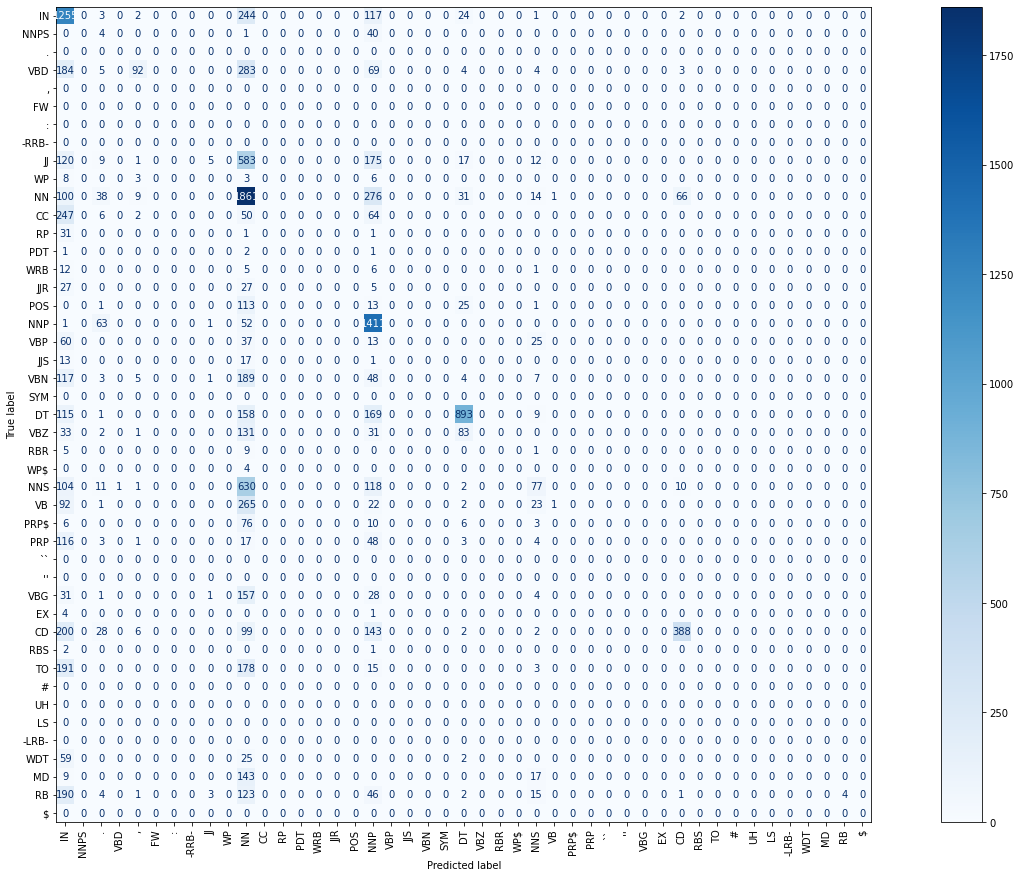

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))
labels = list(set(label_tokenizer.word_to_index.keys()).difference(['<PAD>']))
cm = confusion_matrix(y_true, y_pred, labels=labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, cmap='Blues', xticks_rotation='vertical');

['CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'LS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

# NOTES
- Remove punctuation from evaluation
- We can ignore punctuations when computing loss value, since the network does not have to learn to label them. (ASK PROFESSOR)

## Further improvements
- order sentences according to their length and batch: https://mccormickml.com/2020/07/29/smart-batching-tutorial/#introduction

## 1. Data pipeline

As outlined in the first tutorial, we need to define a proper pipeline to convert initial textual input into a numerical format that is compatible with our models.

This pipeline is usually summarized as follows:

*   Dataset loading
*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation

In this tutorial, we'll propose our solution by following above schema.

### 1.1 Dataset Loading

In [ ]:
def read_dataset_split(dataset_folder, start, end, split:str):
  tagged_sentences = []
  for data_file in range(start, end+1):
    filename = os.path.join(dataset_folder, "wsj_%04d.dp" % data_file)
    with open(filename, mode='r', encoding='utf-8') as text_file:  
      corpus = text_file.read()
      tagged_sentences += corpus.split("\n\n")

  X = [] # store input sequence
  Y = [] # store output sequence
  for sentence in tqdm(tagged_sentences):
      X_sentence = []
      Y_sentence = []

      for tagged_word in sentence.rstrip('\n').split("\n"):       
          entity = tagged_word.split("\t")
          X_sentence.append(entity[0])  # entity[0] contains the word
          Y_sentence.append(entity[1])  # entity[1] contains corresponding tag          
      X.append(X_sentence)
      Y.append(Y_sentence)

  assert len(tagged_sentences) == len(X)

  df = pd.DataFrame({'sentence':X, 'tags':Y})
  df['split'] = split
  return df

def load_dataset(
    dataset_name="dependency_treebank",
    splits={'train': 100, 'validation':150, 'test':199}
    ):  
  dataset_folder = os.path.join(os.getcwd(), dataset_name)
  dataset = []
  last_index = 0
  for split, end_split in tqdm(splits.items()):
    dataset.append(read_dataset_split(dataset_folder, last_index+1, end_split, split))
    last_index = end_split

  df = pd.concat(dataset)
  dataframe_path = os.path.join(os.getcwd(), dataset_name + ".pkl")
  df.to_pickle(dataframe_path)
  return df

print("Loading dataset...")
df = load_dataset()
print("Loading completed!")

df

Loading dataset...


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


Loading completed!


,sentence,tags,split
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train
...,...,...,...
647,"[They, also, said, that, more, than, a, dozen,...","[PRP, RB, VBD, IN, JJR, IN, DT, NN, NNS, VBP, ...",test
648,"[Sen., Kennedy, said, in, a, separate, stateme...","[NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",test
649,"[Trinity, Industries, Inc., said, it, reached,...","[NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",test
650,"[Terms, were, n't, disclosed, .]","[NNS, VBD, RB, VBN, .]",test


### 1.2 Dataset preprocessing

In [ ]:
def word_prepare(word: str):
  return word

df['sentence'] = df['sentence'].apply(lambda words: [word_prepare(word) for word in words])
df

,sentence,tags,split
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train
...,...,...,...
647,"[They, also, said, that, more, than, a, dozen,...","[PRP, RB, VBD, IN, JJR, IN, DT, NN, NNS, VBP, ...",test
648,"[Sen., Kennedy, said, in, a, separate, stateme...","[NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",test
649,"[Trinity, Industries, Inc., said, it, reached,...","[NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",test
650,"[Terms, were, n't, disclosed, .]","[NNS, VBD, RB, VBN, .]",test


### 1.3 Data splitting

In [ ]:
train_data = df[df['split'] == 'train']
val_data = df[df['split'] == 'validation']
test_data = df[df['split'] == 'test']

print('Dataset splits statistics: ')
print(f'Train data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset splits statistics: 
Train data: (1963, 3)
Validation data: (1299, 3)
Test data: (652, 3)


### 1.4 Data Conversion

In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str='glove', embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [ ]:
class Tokenizer:
  def __init__(self, vocabulary=None, padding='<PAD>'):
    """
    Transform a set of sentences in a set of indices.
    The order of enumeration respects the order of the set of sentences used in the fit_on_texts method.
    """
    self.word_to_index = {padding: 0}
    self.idx_to_word = {0: padding}
    self.__idx = 1

    if vocabulary:
      self.update_vocabulary(vocabulary)

  def get_oov_terms(self, words):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    words_in_vocabulary = set(self.word_to_index.keys())
    oov = set(words).difference(words_in_vocabulary)
    return list(oov)

  def update_vocabulary(self, sentences, verbose=True):
    """
    Update the vocabulary by looking at the list of sentences in input
    """
    
    words = set(token for tokens in sentences for token in tokens)
    oov_terms = self.get_oov_terms(words)

    old_len = len(self.word_to_index)
    self.__expand_vocabulary(oov_terms)

    if verbose:
      oov_percentage = float(len(oov_terms)) * 100 / len(words)
      print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

      print("Vocabulary length before expansion:", old_len)
      print("Vocabulary length after expansion:", len(self.word_to_index))

    return oov_terms

  def __expand_vocabulary(self, oov_terms: Iterable[str]):
    for term in oov_terms:
      self.word_to_index[term] = self.__idx
      self.idx_to_word[self.__idx] = term
      self.__idx += 1

  def texts_to_sequences(self, sentences) -> List[List[int]]:
    """
    Transform a list of sentences in a list of sequences, according to the current vocabulary
    """
    return list(map(self.text_to_sequence, sentences))

  def text_to_sequence(self, sentence) -> List[int]:
    return list(map(lambda token: self.word_to_index[token], sentence))

  def sequences_to_texts(self, sequences):
    """
    Transform a list of sequences in a list of sentences, according to the current vocabulary
    """
    return list(map(self.sequence_to_text, sequences))
  
  def sequence_to_text(self, sequence):
    return list(map(lambda idx: self.idx_to_word[idx], sequence))

class EmbeddingMatrix():
  def __init__(self,
               embedding_model: gensim.models.keyedvectors.KeyedVectors,
               embedding_dimension,
               word_to_idx: Dict[str, int],
               oov_vector_factory = None) -> None:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: dimension of the vectors in the embedding space
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    self.oov_vector_factory = oov_vector_factory if oov_vector_factory else lambda: np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

    vocab_size = len(word_to_idx)
    self.embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
      if word in embedding_model:
        embedding_vector = embedding_model[word]
      else:
        embedding_vector = self.oov_vector_factory()

      self.embedding_matrix[idx] = embedding_vector

  def update_matrix(self, word_to_idx: Dict[str, int]):
    old_vocab_size = len(self.embedding_matrix)
    vocab_size = len(word_to_idx)
    embedding_dimension = self.embedding_matrix.shape[1]

    self.embedding_matrix.resize((vocab_size, embedding_dimension))
    for word, idx in tqdm(word_to_idx.items()):
      if idx > old_vocab_size -1:
        self.embedding_matrix[idx] = self.oov_vector_factory()

  def as_numpy(self):
    return self.embedding_matrix

def add_oov(dataset, dataset_name: str):
  print()
  print(f'Adding {dataset_name} vocabulary ...')
  tokenizer.update_vocabulary(dataset.sentence)
  embedding_matrix.update_matrix(tokenizer.word_to_index)

In [ ]:
embedding_dimension=50

embedding_model = load_embedding_model(model_type="glove", embedding_dimension=embedding_dimension)
tokenizer = Tokenizer([embedding_model.vocab.keys()])
embedding_matrix = EmbeddingMatrix(embedding_model, embedding_dimension, tokenizer.word_to_index)

add_oov(train_data, 'training set')
add_oov(val_data, 'validation set')
add_oov(test_data, 'test set')

print('\n')
print('Shape of the embedding matrix', embedding_matrix.as_numpy().shape)

Total OOV terms: 400000 (100.00%)
Vocabulary length before expansion: 1
Vocabulary length after expansion: 400001


100%|██████████| 400001/400001 [00:01<00:00, 255142.74it/s]



Adding training set vocabulary ...
Total OOV terms: 2346 (29.29%)
Vocabulary length before expansion: 400001
Vocabulary length after expansion: 402347


100%|██████████| 402347/402347 [00:00<00:00, 1620392.27it/s]



Adding validation set vocabulary ...
Total OOV terms: 944 (16.02%)
Vocabulary length before expansion: 402347
Vocabulary length after expansion: 403291


100%|██████████| 403291/403291 [00:00<00:00, 1587186.58it/s]



Adding test set vocabulary ...
Total OOV terms: 455 (12.56%)
Vocabulary length before expansion: 403291
Vocabulary length after expansion: 403746


100%|██████████| 403746/403746 [00:00<00:00, 1669879.81it/s]



Shape of the embedding matrix (403746, 50)


In [ ]:
class TagsEncoder:
  def __init__(self, tags: List[List[str]]) -> None:
    self.label_tokenizer = Tokenizer()
    self.label_tokenizer.update_vocabulary(tags, verbose=False)
    self.output_dimension = len(self.label_tokenizer.idx_to_word)
  
  def texts_to_ids(self, tags: List[List[str]]) -> List[List[int]]:
    return self.label_tokenizer.texts_to_sequences(tags)
  
  def ids_to_categorical(self, encoded_tags: List[List[int]]):
    return ks.utils.to_categorical(encoded_tags, num_classes=self.output_dimension)

  def categorical_to_ids(self, one_hot_tags: List[List[List[int]]]) -> np.ndarray:
    return np.argmax(one_hot_tags, axis=-1)

  def ids_to_texts(self, encoded_tags: List[List[int]]) -> List[List[str]]:
    return self.label_tokenizer.sequences_to_texts(encoded_tags)

def pad(sentences: tf.RaggedTensor, tags: tf.RaggedTensor):
  sentences = sentences.to_tensor(default_value=0)
  tags = tags.to_tensor(default_value=0)

  return sentences, tags

def create_dataloader(dataset, tokenizer, tags_encoder, batch_size=32, training=True):
  # one_hot_encoding = functools.partial(tags_encoder.ids_to_categorical)

  encoded_sentences = tokenizer.texts_to_sequences(dataset.sentence)
  encoded_tags = tags_encoder.texts_to_ids(dataset.tags)

  # convert list of list to raggedTensor, i.e. tensor with non-uniform shape
  encoded_sentences = tf.ragged.constant(encoded_sentences)
  encoded_tags = tf.ragged.constant(encoded_tags)

  dataset = (
      tf.data.Dataset.from_tensor_slices((encoded_sentences, encoded_tags))
      .prefetch(buffer_size=tf.data.AUTOTUNE))
  
  if training:
    dataset = dataset.shuffle(buffer_size=2048)

  dataset = (
      dataset.shuffle(buffer_size=2048)
      .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
      .map(pad, num_parallel_calls=tf.data.AUTOTUNE)
      .map(lambda sentences, tags: (sentences, tf.one_hot(tags, depth=tags_encoder.output_dimension)),
           num_parallel_calls=tf.data.AUTOTUNE)
      )
  
  return dataset

tags_encoder = TagsEncoder(df.tags.values)
assert tags_encoder.output_dimension == len(np.unique([tag for sentence in df.tags for tag in sentence])) + 1
dataloader = create_dataloader(train_data, tokenizer, tags_encoder)

In [ ]:
batched_text, batched_tags = next(dataloader.take(1).as_numpy_iterator())
text = batched_text[0]
tags = batched_tags[0]

print('Encoded text:', text.shape)
print(text)
print('One hot encoded tags:', tags.shape)
print(tags)

Encoded text: (63,)
[401925 341448 283268 201932 269423 401079 283268 127991 208549 128577
 298519 175862 247168  88920      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0]
One hot encoded tags: (63, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### 1.5 Model Definition

In [ ]:
def create_model(embedding_weights, n_labels, compile_info):
  inputs = ks.layers.Input(shape=(None, ))
  x = ks.layers.Embedding(*embedding_weights.shape, weights=[embedding_weights],
                          mask_zero=True, trainable=False)(inputs)
  x = ks.layers.Bidirectional(ks.layers.LSTM(units=64, return_sequences=True))(x)
  x = ks.layers.TimeDistributed(ks.layers.Dense(n_labels, activation='softmax'))(x)

  model = ks.models.Model(inputs, x)
  model.summary()
  model.compile(**compile_info)

  return model

embedding_weights = embedding_matrix.as_numpy()

In [ ]:
compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
}
model = create_model(embedding_weights, n_labels=tags_encoder.output_dimension, compile_info=compile_info)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          20187300  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, None, 46)         5934      
 tributed)                                                       
                                                                 
Total params: 20,252,114
Trainable params: 64,814
Non-trainable params: 20,187,300
_________________________________________________________________


### 1.6 Training

In [ ]:
def show_history(history: ks.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
def train_model(model: ks.Model,
                train_data: tf.data.Dataset,
                val_data: tf.data.Dataset,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param train_data: training data
    :param val_data: validation data
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=train_data,
                        validation_data=val_data,
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return model

Start training! 
Parameters: {'verbose': 1, 'epochs': 5, 'batch_size': 64}
Epoch 1/5
31/31 [==============================] - 5s 167ms/step - loss: 0.8697 - accuracy: 0.4918 - val_loss: 0.9032 - val_accuracy: 0.5228
Epoch 2/5
31/31 [==============================] - 5s 171ms/step - loss: 0.7037 - accuracy: 0.5657 - val_loss: 0.7408 - val_accuracy: 0.5869
Epoch 3/5
31/31 [==============================] - 5s 176ms/step - loss: 0.5879 - accuracy: 0.6332 - val_loss: 0.6328 - val_accuracy: 0.6444
Epoch 4/5
31/31 [==============================] - 6s 203ms/step - loss: 0.5051 - accuracy: 0.6828 - val_loss: 0.5788 - val_accuracy: 0.6795
Epoch 5/5
31/31 [==============================] - 7s 242ms/step - loss: 0.4686 - accuracy: 0.7149 - val_loss: 0.5396 - val_accuracy: 0.7072
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


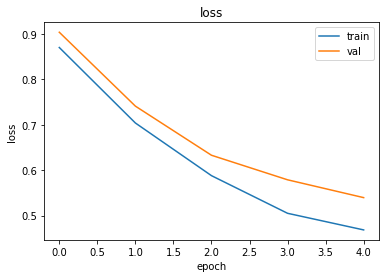

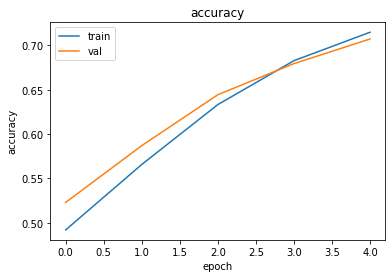

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': 5,
    'batch_size': 64,
}

train_dataloader = create_dataloader(train_data, tokenizer, tags_encoder, batch_size=training_info['batch_size'])
val_dataloader = create_dataloader(val_data, tokenizer, tags_encoder, batch_size=training_info['batch_size'])
model = train_model(model=model, train_data=train_dataloader, val_data=val_dataloader, training_info=training_info)

### 1.7 Evaluation

In [ ]:
test_loader = create_dataloader(test_data, tokenizer, tags_encoder, training=False)
r = model.predict(test_loader)

21/21 [==============================] - 1s 47ms/step


In [ ]:
max_length = max(len(tokens) for tokens in test_data.sentence)
predictions = r.to_tensor(default_value=0)
assert len(predictions) == len(test_data)
assert predictions.shape[1] == max_length

encoded_tags = tags_encoder.categorical_to_ids(predictions.numpy())
assert predictions.shape[:2] == encoded_tags.shape

(652, 58)


array([[19, 25, 15, ...,  0,  0,  0],
       [24,  9, 30, ...,  0,  0,  0],
       [19, 19,  3, ...,  0,  0,  0],
       ...,
       [19, 25, 15, ...,  0,  0,  0],
       [32, 17, 33, ...,  0,  0,  0],
       [32, 32, 24, ...,  0,  0,  0]])

In [ ]:
def predict_data(model: ks.Model,
                 x: tf.data.Dataset,
                 prediction_info: Dict) -> tf.RaggedTensor:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')

    predictions = model.predict(x, **prediction_info)
    return predictions

def predictions_to_ids(predictions: tf.RaggedTensor):
    max_length = max(len(tokens) for tokens in test_data.sentence)
    predictions = predictions.to_tensor(default_value=0)
    assert predictions.shape[1] == max_length

    encoded_tags = tags_encoder.categorical_to_ids(predictions.numpy())
    assert predictions.shape[:2] == encoded_tags.shape

    return encoded_tags

# TP BE FINISHED
def evaluate(model, dataset: pd.DataFrame, metric, banned_tags):
  # # TODO: remove punctuation
  # sentences, tags = preprocessing(dataset)
  # y_pred = predict(model, sentences).reshape(-1)

  # padding_mask = compute_padding_mask(tags)
  # padding_mask = np.reshape(padding_mask, -1)  
  # assert len(padding_mask) == len(y_pred), f'{len(padding_mask)} != {len(y_pred)}'

  # y_true = test_set.tags.explode().to_numpy()
  # y_pred = y_pred[padding_mask]
  # assert y_pred.shape == y_true.shape, f'{y_pred.shape} != {y_true.shape}'

  # mask = compute_mask(y_true, banned_tags)
  # assert len(mask) == len(y_true), f'{len(mask)} != {len(y_true)}'
  # assert len(mask) == len(y_pred), f'{len(mask)} != {len(y_pred)}'

  # y_true = y_true[mask]
  # y_pred = y_pred[mask]
  # assert y_pred.shape == y_true.shape, f'{y_pred.shape} != {y_true.shape}'

  # return y_true, y_pred, metric(y_true, y_pred)
  
def evaluate_predictions(y_pred: np.ndarray,
                         y_true: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str],
                         banned_tags: List[str]):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """
    assert len(metrics) == len(metric_names)
    print(f"Evaluating predictions! Total samples: {y.shape[0]}")

    metric_info = {}
    for metric, metric_name in zip(metrics, metric_names):
        metric_value = metric(y_pred=predictions, y_true=y)
        metric_info[metric_name] = metric_value

    return metric_info

In [ ]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}

# Evaluation
metrics = [
    accuracy_score,
    partial(f1_score, pos_label=1, average='binary')
]
metric_names = [
    "accuracy",
    "binary_f1"
]

test_loader = create_dataloader(test_data, tokenizer, tags_encoder, training=False)
test_predictions = predict_data(model=model, x=test_loader, prediction_info=prediction_info)
assert len(test_predictions) == len(test_data)

test_predictions = predictions_to_ids(test_predictions)

metric_info = evaluate_predictions(predictions=test_predictions,
                                   y=y_test,
                                   metrics=metrics,
                                   metric_names=metric_names)

print(f'Metrics info: \n{metric_info}')

In [ ]:
batch_size=128
epochs = 3

train_ds = create_dataloader(train_data, preprocessing, batch_size=batch_size)
val_ds = create_dataloader(val_data, preprocessing, batch_size=batch_size)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

NameError: ignored